# Impact of Trading Horizon and Frequency on the Salopek Strategy

In [1]:
import numpy.typing as npt
import numpy as np
from typing import Union
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# own module
from simulations.fractional_brownian import (
    generate_brownian_path,
    generate_n_assets_portfolio,
)
from backtest.backtester import Backtester
from strategy.strategy import SalopekStrategy

from utility.utils import generate_t, a_order_power_mean, transaction_cost_L

# Horizon

In [7]:
T = np.linspace(0.5, 10, 20)
P = [[0, 0], [0.1, 0], [0.1, 0.5]]
N_SIMULATION = 10
ALPHA = -30
BETA = 30
SCALING_FACTOR = 100

salopek_strat = SalopekStrategy(alpha=ALPHA, beta=BETA)
bk_tester = Backtester()

mean_terminal_portfolio_value_phi = []
mean_terminal_portfolio_value_psi = []
loss_probabilities = []

for probas in P:
    mean_terminal_V_t_psi = []
    mean_terminal_V_t_phi = []
    loss_proba = []
    for t in T:
        terminal_V_t_psi = []
        terminal_V_t_phi = []
        for _ in tqdm(range(N_SIMULATION), leave=False, desc="Computing MC simulation...", total=N_SIMULATION):
            df_ptf = generate_n_assets_portfolio(
                n_assets=2,
                n_steps=251,
                T=t,
                H=0.7,
                mu=0.05,
                sigma=0.1,
                s0=100,
                add_risk_free_asset=False,
                as_dataframe=True,
                brownian_type="fractional",
            )
            _, V_t_psi, V_t_phi, transaction_account = bk_tester.run_backtest(
                universe_dataframe=df_ptf,
                allocation_function=salopek_strat.get_allocation,
                p1=probas[0],
                p2=probas[1],
            )
            terminal_V_t_psi.append(V_t_psi[-2])
            terminal_V_t_phi.append(V_t_phi[-2])
            del df_ptf
        mean_terminal_V_t_phi.append(np.mean(terminal_V_t_phi))
        mean_terminal_V_t_psi.append(np.mean(terminal_V_t_psi))
        loss_proba.append(sum(v < 0 for v in terminal_V_t_phi) / len(terminal_V_t_phi))
    mean_terminal_portfolio_value_phi.append(mean_terminal_V_t_phi)
    mean_terminal_portfolio_value_psi.append(mean_terminal_V_t_psi)
    loss_probabilities.append(loss_proba)


generate all paths of the portfolio:   0%|          | 0/2 [00:00<?, ?it/s]

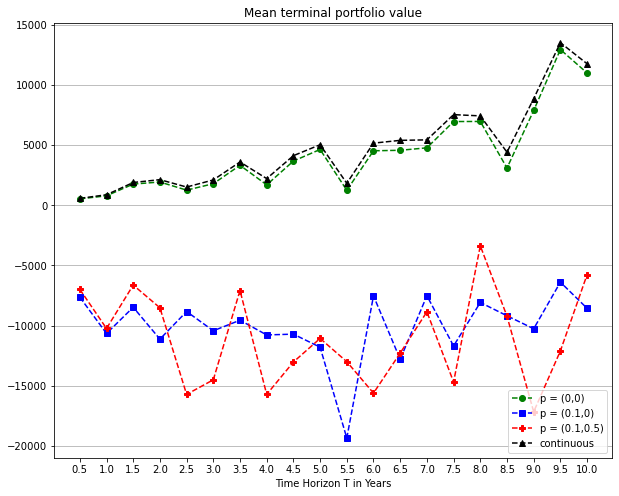

In [24]:
fig = plt.figure(figsize=(10, 8))
plt.plot(T, mean_terminal_portfolio_value_phi[0], 'g--', marker="o", label='p = (0,0)')
plt.plot(T, mean_terminal_portfolio_value_phi[1], 'b--', marker="s", label='p = (0.1,0)')
plt.plot(T, mean_terminal_portfolio_value_phi[2], 'r--', marker='P', label='p = (0.1,0.5)')
plt.plot(T, mean_terminal_portfolio_value_psi[0], 'k--', marker='^', label='continuous')

plt.xlabel('Time Horizon T in Years')
plt.xticks(T)
plt.title('Mean terminal portfolio value')
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

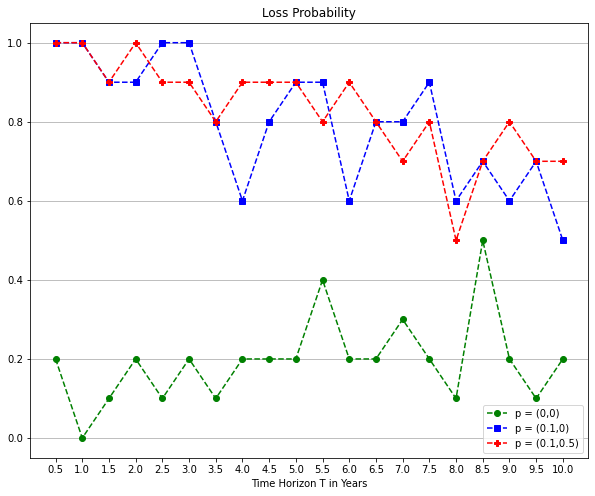

In [25]:
fig = plt.figure(figsize=(10, 8))

plt.plot(T, loss_probabilities[0], 'g--', marker="o", label='p = (0,0)')
plt.plot(T, loss_probabilities[1], 'b--', marker="s", label='p = (0.1,0)')
plt.plot(T, loss_probabilities[2], 'r--', marker='P', label='p = (0.1,0.5)')

plt.xlabel('Time Horizon T in Years')
plt.xticks(T)
plt.title('Loss Probability')
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

# Frequency